# Data Preprocessing & Cleaning

### Importing necessary libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
import numpy as np

### Loading the datasets

In [28]:
ESG = pd.read_csv('ESG_Data.csv')
WEO = pd.read_csv('WEO_Data.csv')

### ESG Data Preprocessing & Cleaning
- Fixed missing 1000 rows growth rates
- Removed duplicates and rows with missing financial targets.
- Converted 'Year' to integer for consistent merging.
- Filled 1,000 missing Growth Rates using Industry Medians (to save data).

In [ ]:
ESG = ESG.drop_duplicates()
ESG = ESG.dropna(subset=['Revenue', 'ProfitMargin', 'ESG_Overall'])
ESG['Year'] = ESG['Year'].astype(int)

industry_medians = ESG.groupby('Industry')['GrowthRate'].median()
ESG['GrowthRate'] = ESG['GrowthRate'].fillna(ESG['Industry'].map(industry_medians))

### WEO Data Preprocessing & Cleaning
- Turn year columns (2015, 2016...) into rows
- Force to string so we can edit the text
- Remove dots/commas, convert to a real number
- Sum GDP by Region & Year

In [35]:
WEO_Processed = WEO.melt(id_vars=['Country'], var_name='Year', value_name='GDP')

WEO_Processed['GDP'] = WEO_Processed['GDP'].astype(str)

WEO_Processed['GDP'] = WEO_Processed['GDP'].str.replace(',', '', regex=False)
WEO_Processed['GDP'] = WEO_Processed['GDP'].str.replace('.', '', regex=False)

WEO_Processed['GDP'] = pd.to_numeric(WEO_Processed['GDP'], errors='coerce')
WEO_Processed['Year'] = pd.to_numeric(WEO_Processed['Year'], errors='coerce')

### Regional Aggregation Strategy
- ESG data is Regional (7 zones), GDP data is Country-level (196 nations).

- Step A (Mapping): Maped each of the 196 countries to one of the 7 ESG regions.
- Step B (Aggregation): Group and SUM GDP data by Region and Year.
- Step C (Merge): Join datasets on ['Region', 'Year'] keys.


In [42]:
country_map = {

    # --- NORTH AMERICA (2) ---
    'United States': 'North America', 'Canada': 'North America',

    # --- LATIN AMERICA (34) ---
    'Mexico': 'Latin America', 'Argentina': 'Latin America', 'Bolivia': 'Latin America',
    'Brazil': 'Latin America', 'Chile': 'Latin America', 'Colombia': 'Latin America',
    'Costa Rica': 'Latin America', 'Dominican Republic': 'Latin America', 'Ecuador': 'Latin America',
    'El Salvador': 'Latin America', 'Guatemala': 'Latin America', 'Haiti': 'Latin America',
    'Honduras': 'Latin America', 'Jamaica': 'Latin America', 'Nicaragua': 'Latin America',
    'Panama': 'Latin America', 'Paraguay': 'Latin America', 'Peru': 'Latin America',
    'Uruguay': 'Latin America', 'Venezuela': 'Latin America', 'Antigua and Barbuda': 'Latin America',
    'Aruba': 'Latin America', 'The Bahamas': 'Latin America', 'Barbados': 'Latin America',
    'Belize': 'Latin America', 'Dominica': 'Latin America', 'Grenada': 'Latin America',
    'Guyana': 'Latin America', 'St. Kitts and Nevis': 'Latin America', 'St. Lucia': 'Latin America',
    'St. Vincent and the Grenadines': 'Latin America', 'Suriname': 'Latin America',
    'Trinidad and Tobago': 'Latin America', 'Puerto Rico': 'Latin America',

    # --- EUROPE (45) ---
    'Albania': 'Europe', 'Andorra': 'Europe', 'Armenia': 'Europe', 'Austria': 'Europe',
    'Belarus': 'Europe', 'Belgium': 'Europe', 'Bosnia and Herzegovina': 'Europe',
    'Bulgaria': 'Europe', 'Croatia': 'Europe', 'Cyprus': 'Europe', 'Czech Republic': 'Europe',
    'Denmark': 'Europe', 'Estonia': 'Europe', 'Finland': 'Europe', 'France': 'Europe',
    'Georgia': 'Europe', 'Germany': 'Europe', 'Greece': 'Europe', 'Hungary': 'Europe',
    'Iceland': 'Europe', 'Ireland': 'Europe', 'Italy': 'Europe', 'Kosovo': 'Europe',
    'Latvia': 'Europe', 'Lithuania': 'Europe', 'Luxembourg': 'Europe', 'Malta': 'Europe',
    'Moldova': 'Europe', 'Montenegro': 'Europe', 'Netherlands': 'Europe', 'North Macedonia': 'Europe',
    'Norway': 'Europe', 'Poland': 'Europe', 'Portugal': 'Europe', 'Romania': 'Europe',
    'Russia': 'Europe', 'San Marino': 'Europe', 'Serbia': 'Europe', 'Slovak Republic': 'Europe',
    'Slovenia': 'Europe', 'Spain': 'Europe', 'Sweden': 'Europe', 'Switzerland': 'Europe',
    'Türkiye': 'Europe', 'Ukraine': 'Europe', 'United Kingdom': 'Europe',

    # --- ASIA (31) ---
    'Afghanistan': 'Asia', 'Bangladesh': 'Asia', 'Bhutan': 'Asia', 'Brunei Darussalam': 'Asia',
    'Cambodia': 'Asia', 'China': 'Asia', 'Hong Kong SAR': 'Asia', 'India': 'Asia',
    'Indonesia': 'Asia', 'Japan': 'Asia', 'Kazakhstan': 'Asia', 'Korea': 'Asia',
    'Kyrgyz Republic': 'Asia', 'Lao P.D.R.': 'Asia', 'Macao SAR': 'Asia', 'Malaysia': 'Asia',
    'Maldives': 'Asia', 'Mongolia': 'Asia', 'Myanmar': 'Asia', 'Nepal': 'Asia',
    'Pakistan': 'Asia', 'Philippines': 'Asia', 'Singapore': 'Asia', 'Sri Lanka': 'Asia',
    'Taiwan Province of China': 'Asia', 'Tajikistan': 'Asia', 'Thailand': 'Asia',
    'Timor-Leste': 'Asia', 'Turkmenistan': 'Asia', 'Uzbekistan': 'Asia', 'Vietnam': 'Asia',

    # --- OCEANIA (14) ---
    'Australia': 'Oceania', 'Fiji': 'Oceania', 'Kiribati': 'Oceania', 'Marshall Islands': 'Oceania',
    'Micronesia': 'Oceania', 'Nauru': 'Oceania', 'New Zealand': 'Oceania', 'Palau': 'Oceania',
    'Papua New Guinea': 'Oceania', 'Samoa': 'Oceania', 'Solomon Islands': 'Oceania',
    'Tonga': 'Oceania', 'Tuvalu': 'Oceania', 'Vanuatu': 'Oceania',

    # --- MIDDLE EAST (16) ---
    'Bahrain': 'Middle East', 'Islamic Republic of Iran': 'Middle East', 'Iraq': 'Middle East',
    'Israel': 'Middle East', 'Jordan': 'Middle East', 'Kuwait': 'Middle East',
    'Lebanon': 'Middle East', 'Oman': 'Middle East', 'Qatar': 'Middle East',
    'Saudi Arabia': 'Middle East', 'Syria': 'Middle East', 'United Arab Emirates': 'Middle East',
    'West Bank and Gaza': 'Middle East', 'Yemen': 'Middle East', 'Azerbaijan': 'Middle East',


    # --- AFRICA (54) ---
    'Algeria': 'Africa', 'Angola': 'Africa', 'Benin': 'Africa', 'Botswana': 'Africa',
    'Burkina Faso': 'Africa', 'Burundi': 'Africa', 'Cabo Verde': 'Africa', 'Cameroon': 'Africa',
    'Central African Republic': 'Africa', 'Chad': 'Africa', 'Comoros': 'Africa',
    'Democratic Republic of the Congo': 'Africa', 'Republic of Congo': 'Africa',
    'Côte d\'Ivoire': 'Africa', 'Djibouti': 'Africa', 'Egypt': 'Africa',
    'Equatorial Guinea': 'Africa', 'Eritrea': 'Africa', 'Eswatini': 'Africa',
    'Ethiopia': 'Africa', 'Gabon': 'Africa', 'The Gambia': 'Africa', 'Ghana': 'Africa',
    'Guinea': 'Africa', 'Guinea-Bissau': 'Africa', 'Kenya': 'Africa', 'Lesotho': 'Africa',
    'Liberia': 'Africa', 'Libya': 'Africa', 'Madagascar': 'Africa', 'Malawi': 'Africa',
    'Mali': 'Africa', 'Mauritania': 'Africa', 'Mauritius': 'Africa', 'Morocco': 'Africa',
    'Mozambique': 'Africa', 'Namibia': 'Africa', 'Niger': 'Africa', 'Nigeria': 'Africa',
    'Rwanda': 'Africa', 'São Tomé and Príncipe': 'Africa', 'Senegal': 'Africa',
    'Seychelles': 'Africa', 'Sierra Leone': 'Africa', 'Somalia': 'Africa', 'South Africa': 'Africa',
    'South Sudan': 'Africa', 'Sudan': 'Africa', 'Tanzania': 'Africa', 'Togo': 'Africa',
    'Tunisia': 'Africa', 'Uganda': 'Africa', 'Zambia': 'Africa', 'Zimbabwe': 'Africa'

}

WEO_Processed['Region'] = WEO_Processed['Country'].map(country_map)
WEO_Regional = WEO_Processed.groupby(['Region', 'Year'])['GDP'].sum().reset_index()

# Merge ESG & Regional WEO together
Merged = pd.merge(ESG, WEO_Regional, on=['Region', 'Year'], how='left')

- Create the Z-score for ESG and ProfitMargin (needed for K-Means)
- Save the final clean file


In [47]:
Merged['ESG_Zscore'] = (Merged['ESG_Overall'] - Merged['ESG_Overall'].mean()) / Merged['ESG_Overall'].std()
Merged['ProfitMargin_Zscore'] = (Merged['ProfitMargin'] - Merged['ProfitMargin'].mean()) / Merged['ProfitMargin'].std()

Merged.to_csv('ESG_WEO_Merged.csv', index=False)

# VISUALIZATIONS


### Scatter plot of ESG Score vs. Profit Margin


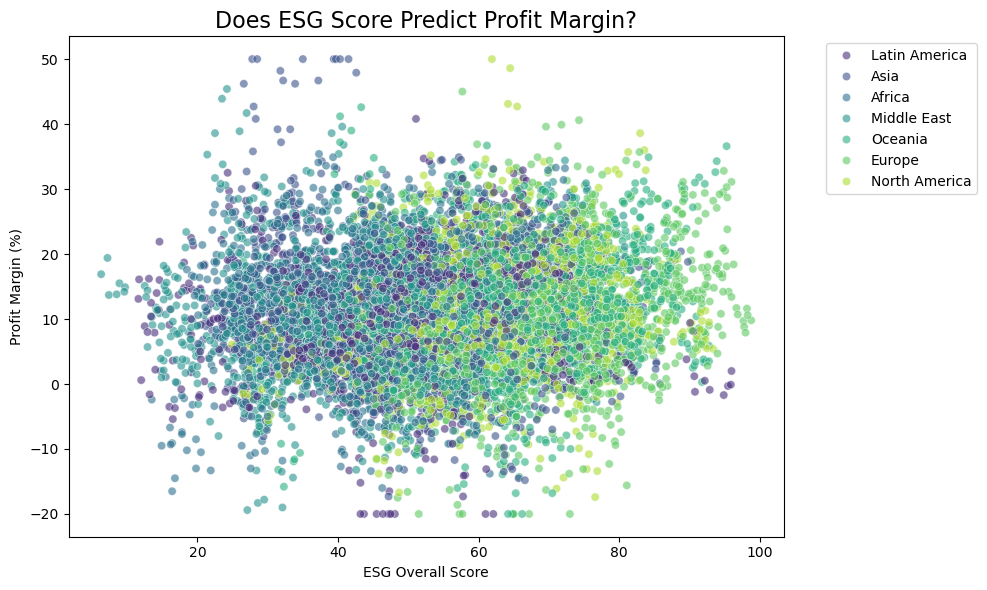

In [52]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=Merged, x='ESG_Overall', y='ProfitMargin', hue='Region', alpha=0.6, palette='viridis')
plt.title('Does ESG Score Predict Profit Margin?', fontsize=16)
plt.xlabel('ESG Overall Score')
plt.ylabel('Profit Margin (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### A 3-panel dashboard of ESG Score vs. Environmental Impact
- Carbon Emissions
- Water Usage
- Energy Consumption


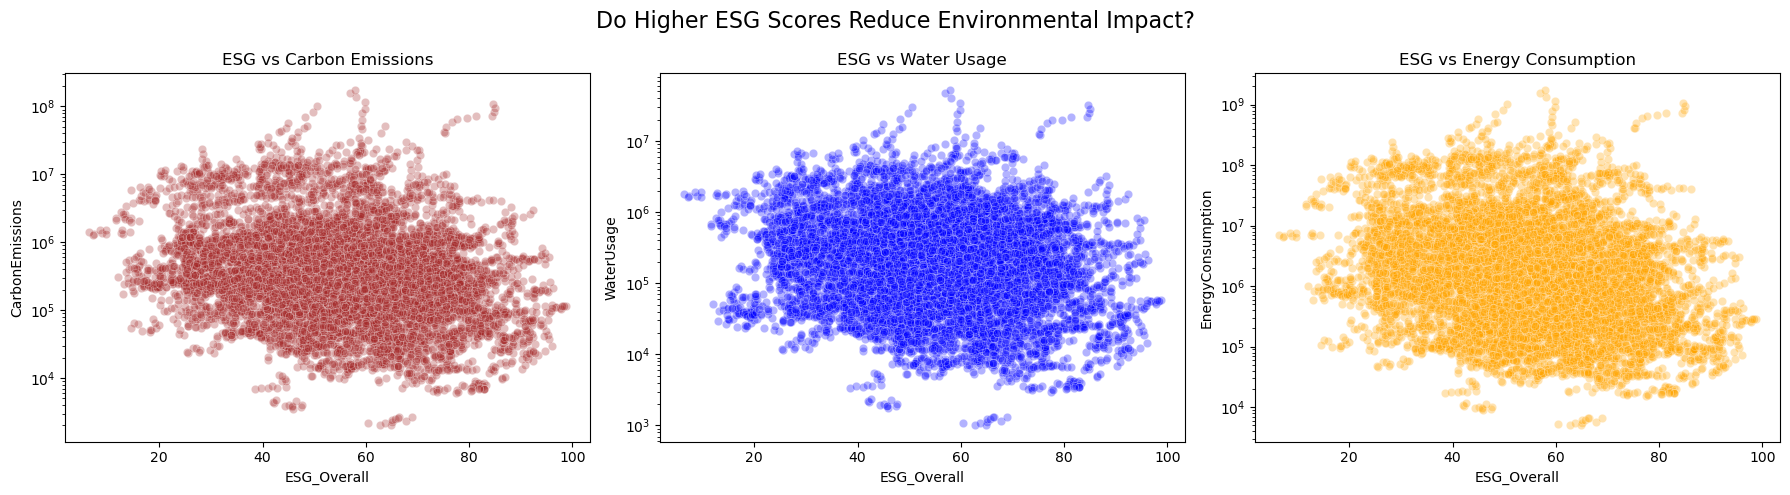

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(ax=axes[0], data=Merged, x='ESG_Overall', y='CarbonEmissions', color='brown', alpha=0.3)
axes[0].set_title('ESG vs Carbon Emissions')
axes[0].set_yscale('log')

sns.scatterplot(ax=axes[1], data=Merged, x='ESG_Overall', y='WaterUsage', color='blue', alpha=0.3)
axes[1].set_title('ESG vs Water Usage')
axes[1].set_yscale('log')

sns.scatterplot(ax=axes[2], data=Merged, x='ESG_Overall', y='EnergyConsumption', color='orange', alpha=0.3)
axes[2].set_title('ESG vs Energy Consumption')
axes[2].set_yscale('log')

plt.suptitle('Do Higher ESG Scores Reduce Environmental Impact?', fontsize=16)
plt.tight_layout()
plt.show()

### Scatter plot of Average Regional GDP vs. Average ESG Score

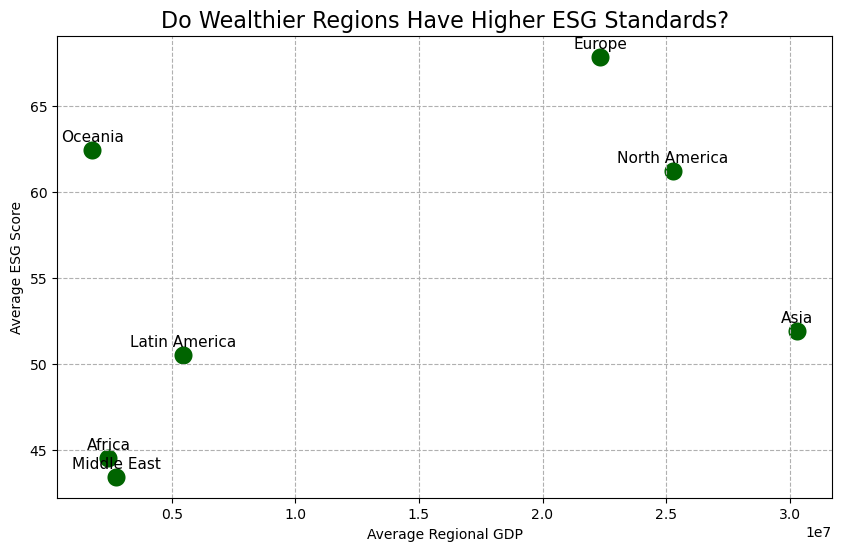

In [63]:
regional_summary = Merged.groupby('Region')[['GDP', 'ESG_Overall']].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=regional_summary, x='GDP', y='ESG_Overall', s=200, color='darkgreen')

for i in range(regional_summary.shape[0]):
    plt.text(regional_summary.GDP[i], regional_summary.ESG_Overall[i]+0.5,
             regional_summary.Region[i], fontsize=11, ha='center')

plt.title('Do Wealthier Regions Have Higher ESG Standards?', fontsize=16)
plt.xlabel('Average Regional GDP')
plt.ylabel('Average ESG Score')
plt.grid(True, linestyle='--')
plt.show()

### Box Plots of Profit Margin by Industry (sorted high-to-low)


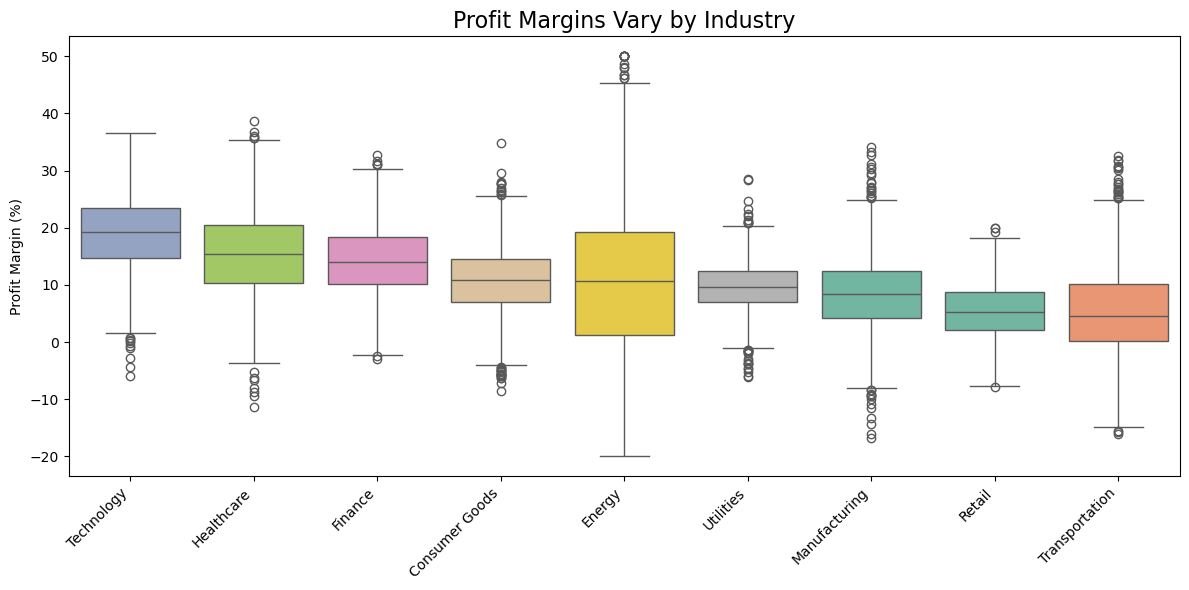

In [68]:
plt.figure(figsize=(12, 6))

sorted_index = Merged.groupby('Industry')['ProfitMargin'].median().sort_values(ascending=False).index

sns.boxplot(data=Merged, x='Industry', y='ProfitMargin', hue='Industry', order=sorted_index, palette='Set2',legend=False)
plt.title('Profit Margins Vary by Industry', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Profit Margin (%)')
plt.xlabel('')
plt.tight_layout()
plt.show()

# STATISTICAL INFERENCE (HYPOTHESIS TESTING)


- **H0 (Null Hypothesis):** ESG performance has no meaningful relationship with financial or environmental outcomes.
- **H1 (Alternative Hypothesis):** Companies with **higher ESG performance** tend to exhibit **better financial performance** (e.g., higher ProfitMargin) and **lower environmental impact** (e.g., lower CarbonEmissions, WaterUsage, EnergyConsumption).


In order to validate visual trends, I applied formal hypothesis tests (p < 0.05):

- **Pearson Correlation (r):**                                                
  - Tested the linear relationship between ESG_Overall and ProfitMargin.Tested ESG_Overall against all three environmental metrics (Carbon, Water, Energy)
- **Independent T-Test:**
  - Compared ESG scores between "High GDP" and "Low GDP" regions to determine if economic maturity is a confounding variable.

### ESG Score vs. Profit Margin

In [85]:
# Cleaned the data specifically for this pair
esg_profit_data = Merged.dropna(subset=['ESG_Overall', 'ProfitMargin'])
corr_coef, p_value = pearsonr(esg_profit_data['ESG_Overall'], esg_profit_data['ProfitMargin'])

print("\nPearson Correlation (r): {:.4f}".format(corr_coef))
print("P-value:                 {:.4e}".format(p_value))

if p_value < 0.05:
    if corr_coef > 0:
        print("\nReject H0 (Significant relationship).")
        print("Higher ESG scores correlate with higher profit margins.")
    else:
        print("Interpretation: Higher ESG scores correlate with LOWER profit margins.")
else:
    print("\nFAIL TO REJECT H0 (No significant relationship).")
    print("ESG scores do not meaningfully predict profit margins.")



Pearson Correlation (r): 0.0880
P-value:                 2.3069e-20

Reject H0 (Significant relationship).
Higher ESG scores correlate with higher profit margins.


### ESG Score vs. Environmental Impact

In [92]:
metrics = ['CarbonEmissions', 'WaterUsage', 'EnergyConsumption']

for metric in metrics:
    metric_data = Merged.dropna(subset=['ESG_Overall', metric])
    corr, p_val = pearsonr(metric_data['ESG_Overall'], metric_data[metric])

    print("\nTarget Variable: {}".format(metric))
    print("Correlation (r): {:.4f}".format(corr))
    print("P-value:         {:.4e}".format(p_val))

    if p_val < 0.05:
        if corr < 0:
            print("\n   Reject H0 (Significant relationship).")
            print("   Higher ESG scores are linked to lower {}.".format(metric))
        else:
            print("   Higher ESG scores are linked to HIGHER {}.".format(metric))
    else:
        print("\n   FAIL TO REJECT H0 (No significant relationship).")
        print("   No clear link between ESG and {}.".format(metric))


Target Variable: CarbonEmissions
Correlation (r): -0.0397
P-value:         3.1543e-05

   Reject H0 (Significant relationship).
   Higher ESG scores are linked to lower CarbonEmissions.

Target Variable: WaterUsage
Correlation (r): -0.0429
P-value:         6.7273e-06

   Reject H0 (Significant relationship).
   Higher ESG scores are linked to lower WaterUsage.

Target Variable: EnergyConsumption
Correlation (r): -0.0436
P-value:         4.6587e-06

   Reject H0 (Significant relationship).
   Higher ESG scores are linked to lower EnergyConsumption.
